## Uber Data Analysis to predict the price

In [42]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc 
import os
import sys
%matplotlib inline

In [43]:
def reduce_mem_usage(df):
    """iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                   
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
        
                elif c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16) 
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem=df.memory_usage().sum( ) / 1024**2
    print('Memory usage dataframe is {:.2f} MB --> {:.2f} MB (decreased by {:.1f})%'.format(
        start_mem,end_mem, 100 * (start_mem-end_mem)/start_mem))
    return df

In [44]:
cab_data = pd.read_csv("cab_rides.csv")
cab_data = reduce_mem_usage(cab_data)
weather_data = pd.read_csv("weather.csv")
weather_data = reduce_mem_usage(weather_data)

Memory usage dataframe is 52.88 MB --> 50.23 MB (decreased by 5.0)%
Memory usage dataframe is 0.38 MB --> 0.36 MB (decreased by 6.2)%


In [45]:
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1.544953e+12,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1.543284e+12,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1.543367e+12,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1.543554e+12,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1.543463e+12,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [46]:
weather_data.head()


,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1.545004e+09,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1.545004e+09,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1.545004e+09,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1.545004e+09,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1.545004e+09,0.75,11.49


In [85]:
cab_data.shape

(693071, 11)

In [84]:
cab_data.dtypes


distance                   float64
cab_type                    object
time_stamp                 float32
destination                 object
source                      object
price                      float64
surge_multiplier           float64
id                          object
product_id                  object
name                        object
datetime            datetime64[ns]
dtype: object

In [48]:
weather_data.shape

(6276, 8)

In [49]:
cab_data.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name'],
      dtype='object')

In [50]:
weather_data.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind'],
      dtype='object')

In [52]:
#converting time_stamp into datetime
import datetime        
cab_data['datetime']=pd.to_datetime(cab_data['time_stamp'])
cab_data
weather_data['date_time']=pd.to_datetime(weather_data['time_stamp'])

In [53]:
weather_data.shape

(6276, 9)

In [54]:
cab_data.shape

(693071, 11)

In [55]:
cab_data.describe()

,distance,time_stamp,price,surge_multiplier,datetime
count,693071.000000,6.930710e+05,637976.000000,693071.000000,693071
mean,2.189430,1.544046e+12,16.545125,1.013870,1970-01-01 00:25:44.045709886
min,0.020000,1.543204e+12,2.500000,1.000000,1970-01-01 00:25:43.203586048
25%,1.280000,1.543444e+12,9.000000,1.000000,1970-01-01 00:25:43.443972096
50%,2.160000,1.543737e+12,13.500000,1.000000,1970-01-01 00:25:43.737442304
75%,2.920000,1.544828e+12,22.500000,1.000000,1970-01-01 00:25:44.827568128
max,7.860000,1.545160e+12,97.500000,3.000000,1970-01-01 00:25:45.160491008
std,1.138937,6.891923e+08,9.324359,0.091641,NaN


In [56]:
weather_data.describe()

,temp,clouds,pressure,rain,time_stamp,humidity,wind,date_time
count,6276.000000,6276.000000,6276.000000,894.000000,6.276000e+03,6276.000000,6276.000000,6276
mean,39.090475,0.677777,1008.445209,0.057652,1.543857e+09,0.763985,6.802812,1970-01-01 00:00:01.543857376
min,19.620000,0.000000,988.250000,0.000200,1.543204e+09,0.450000,0.290000,1970-01-01 00:00:01.543203584
25%,36.077500,0.440000,997.747500,0.004900,1.543387e+09,0.670000,3.517500,1970-01-01 00:00:01.543386880
50%,40.130000,0.780000,1007.660000,0.014850,1.543514e+09,0.760000,6.570000,1970-01-01 00:00:01.543513984
75%,42.832500,0.970000,1018.480000,0.060925,1.544691e+09,0.890000,9.920000,1970-01-01 00:00:01.544690688
max,55.410000,1.000000,1035.120000,0.780700,1.545159e+09,0.990000,18.180000,1970-01-01 00:00:01.545158656
std,6.022055,0.314284,12.870775,0.100758,6.659316e+05,0.127340,3.633466,NaN


In [57]:
a=pd.concat([cab_data,weather_data])   #concatenate both the data

In [58]:
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind,date_time
0,0.44,Lyft,1.544953e+12,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,1970-01-01 00:25:44.952610816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,0.44,Lyft,1.543284e+12,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,1970-01-01 00:25:43.284064256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,0.44,Lyft,1.543367e+12,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,1970-01-01 00:25:43.366770688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,0.44,Lyft,1.543554e+12,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,1970-01-01 00:25:43.553548288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,0.44,Lyft,1.543463e+12,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,1970-01-01 00:25:43.463370752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [59]:
a['day']=a.date_time.dt.day
a['hour']=a.date_time.dt.hour

In [60]:
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,temp,location,clouds,pressure,rain,humidity,wind,date_time,day,hour
0,0.44,Lyft,1.544953e+12,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1,0.44,Lyft,1.543284e+12,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2,0.44,Lyft,1.543367e+12,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
3,0.44,Lyft,1.543554e+12,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
4,0.44,Lyft,1.543463e+12,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [61]:
a.tail()
#here we get the value of day and hour

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,temp,location,clouds,pressure,rain,humidity,wind,date_time,day,hour
6271,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.72,North Station,0.89,1000.69,NaN,0.96,1.52,1970-01-01 00:00:01.543820032,1.0,0.0
6272,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.85,Northeastern University,0.88,1000.71,NaN,0.96,1.54,1970-01-01 00:00:01.543820032,1.0,0.0
6273,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.82,South Station,0.89,1000.70,NaN,0.96,1.54,1970-01-01 00:00:01.543820032,1.0,0.0
6274,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.78,Theatre District,0.89,1000.70,NaN,0.96,1.54,1970-01-01 00:00:01.543820032,1.0,0.0
6275,NaN,NaN,1.543820e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.69,West End,0.89,1000.70,NaN,0.96,1.52,1970-01-01 00:00:01.543820032,1.0,0.0


In [62]:
#fill NAN value with 0 using fillna
a.fillna(0,inplace=True)

In [63]:
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,temp,location,clouds,pressure,rain,humidity,wind,date_time,day,hour
0,0.44,Lyft,1.544953e+12,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,0.44,Lyft,1.543284e+12,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,0.44,Lyft,1.543367e+12,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,0.44,Lyft,1.543554e+12,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,0.44,Lyft,1.543463e+12,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [64]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind',
       'date_time', 'day', 'hour'],
      dtype='object')

In [65]:
#There are two types of cab_type if we want to see what are they 
#We use groupby

a.groupby('cab_type').count()  #this will count the whole numbers(add them)

,distance,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind,date_time,day,hour
cab_type,,,,,,,,,,,,,,,,,,,,
0,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276
Lyft,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408
Uber,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663


<AxesSubplot:xlabel='cab_type'>

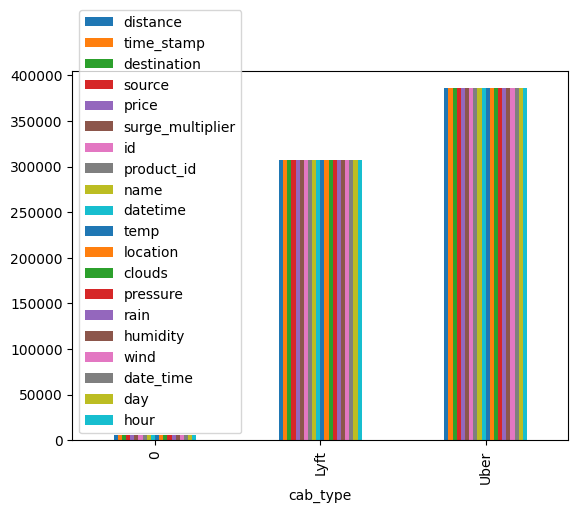

In [66]:
a.groupby('cab_type').count().plot.bar()

<AxesSubplot:xlabel='price'>

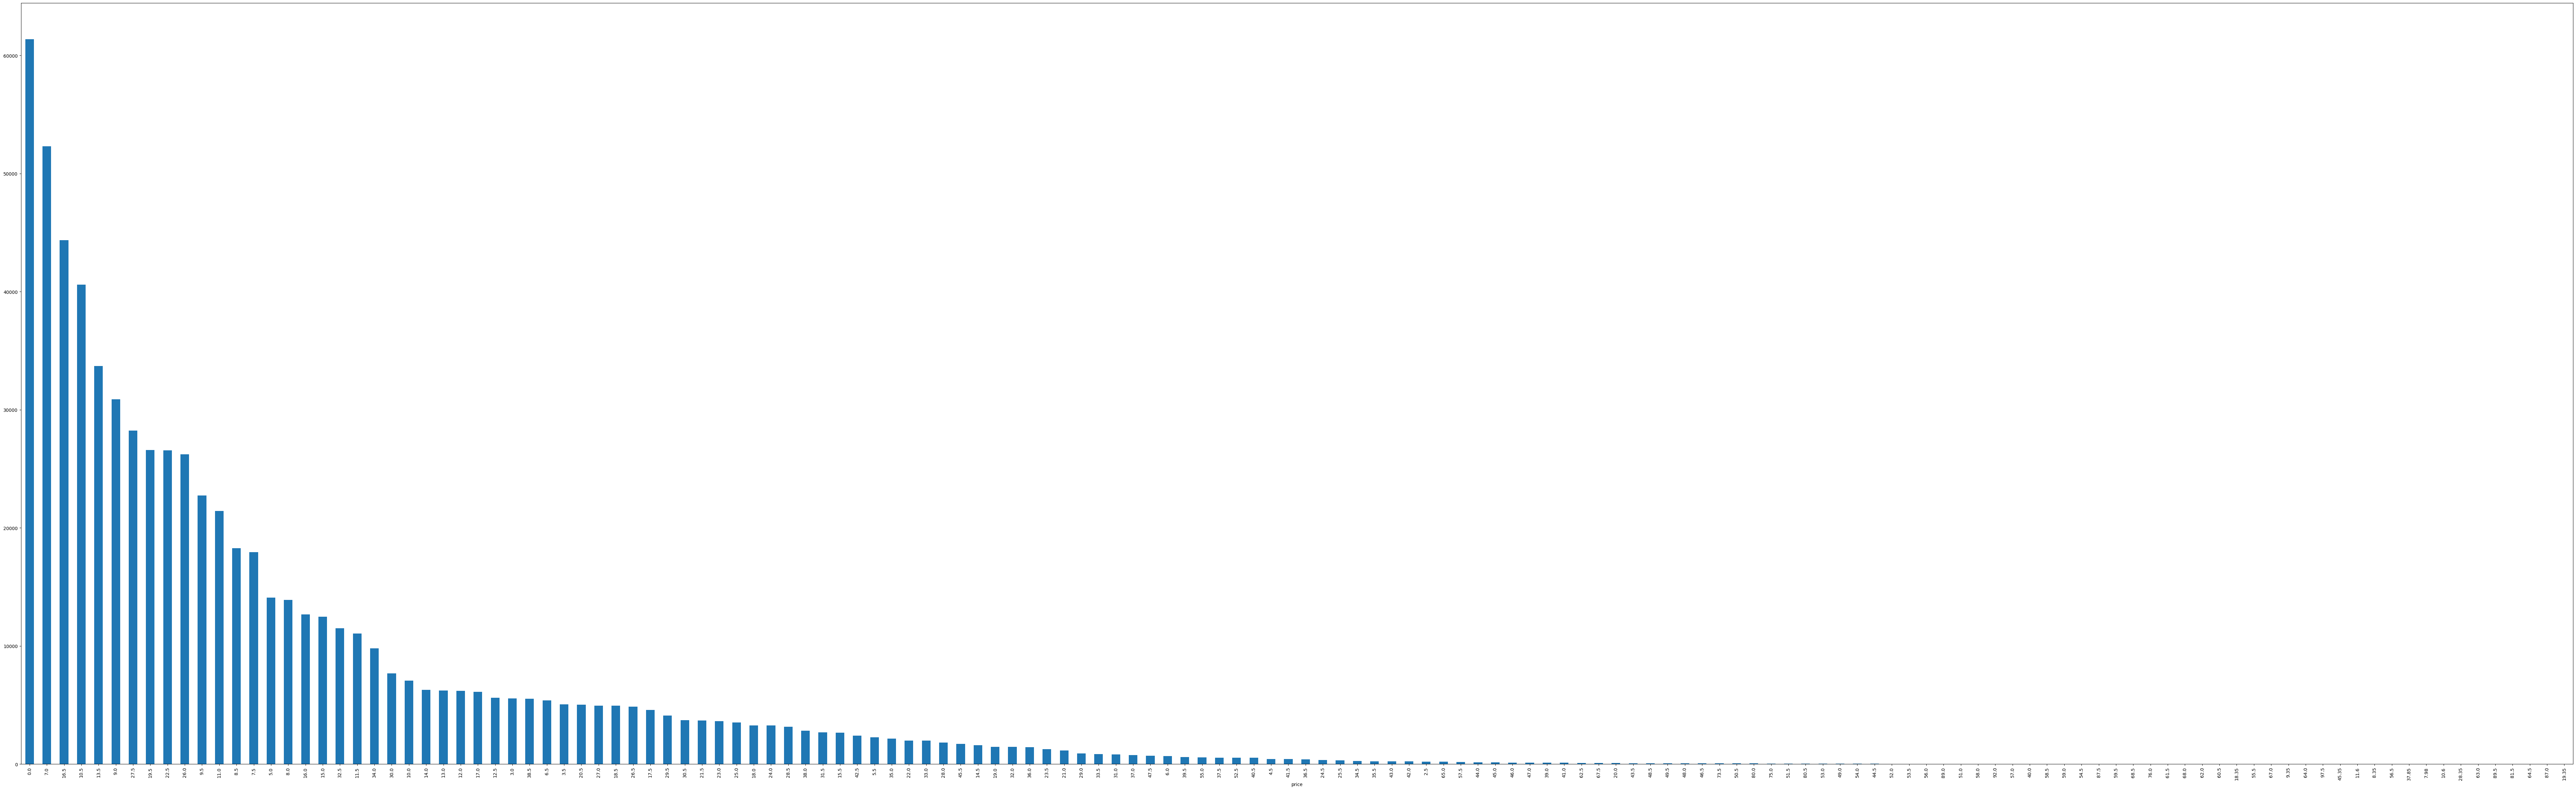

In [90]:
a['price'].value_counts().plot.bar(figsize=(100,30),xlabel='price')  #flaxuation of price


<AxesSubplot:xlabel='hour'>

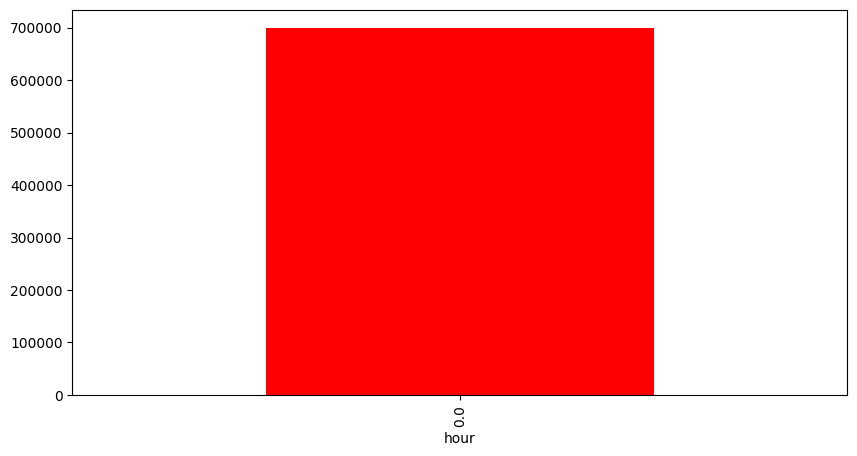

In [71]:
#To find the peek hour for cab

a['hour'].value_counts().plot.bar(figsize=(10,5),color='r')

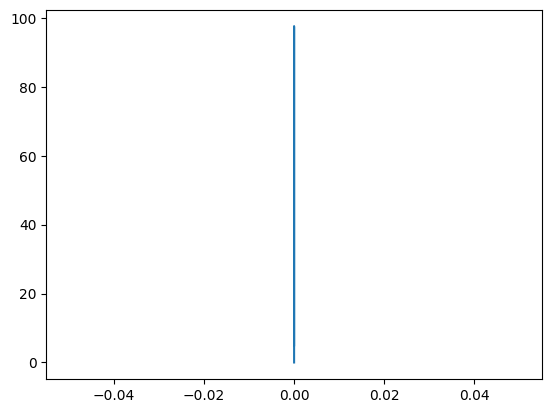

In [72]:
x=a['hour']
y=a['price']
plt.plot(x,y)
plt.show()

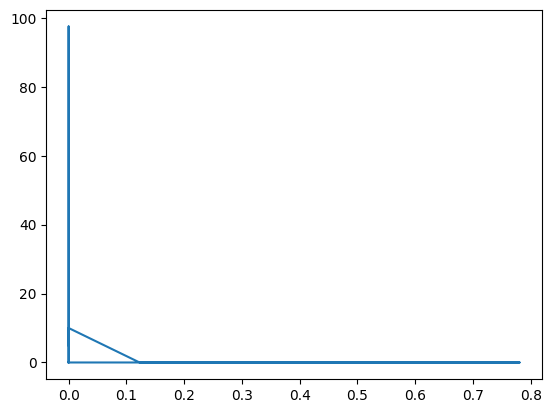

In [74]:
x=a['rain']
y=a['price']
plt.plot(x,y)
plt.show()

### Data Modeling

In [75]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind',
       'date_time', 'day', 'hour'],
      dtype='object')

In [76]:
#x1 main attributes to train data model(x1=training data)

x1=a[['distance','temp','pressure','humidity','wind','rain','day','hour','surge_multiplier','clouds']]
#(y1=label data)
y1=a['price']

In [77]:
#using skicit-learn to split data into training and testing sets

from sklearn.model_selection import train_test_split

#split the data into training and testing sets
x_train,y_train,x_test,y_test = train_test_split(x1,y1,test_size=0.25,random_state =42)

In [78]:
linear=LinearRegression()
linear.fit(x_train,x_test)   #x_train=attributes(train data) y= price(label data)

LinearRegression()

In [79]:
predictions= linear.predict(y_train)
predictions     #predicted value

array([32.54791635, 14.75560763, 16.81696874, ..., 11.82898384,
       11.85443274, 13.22867348])

In [80]:
df=pd.DataFrame({'Actual':y_test,'predicted':predictions})
df

,Actual,predicted
81607,42.5,32.547916
354,0.0,14.755608
471801,32.5,16.816969
407645,27.5,10.480192
474760,27.5,10.556539
...,...,...
538489,7.5,10.709232
579511,13.5,15.519075
5421,9.0,11.828984
279982,8.0,11.854433


### Data Visualization

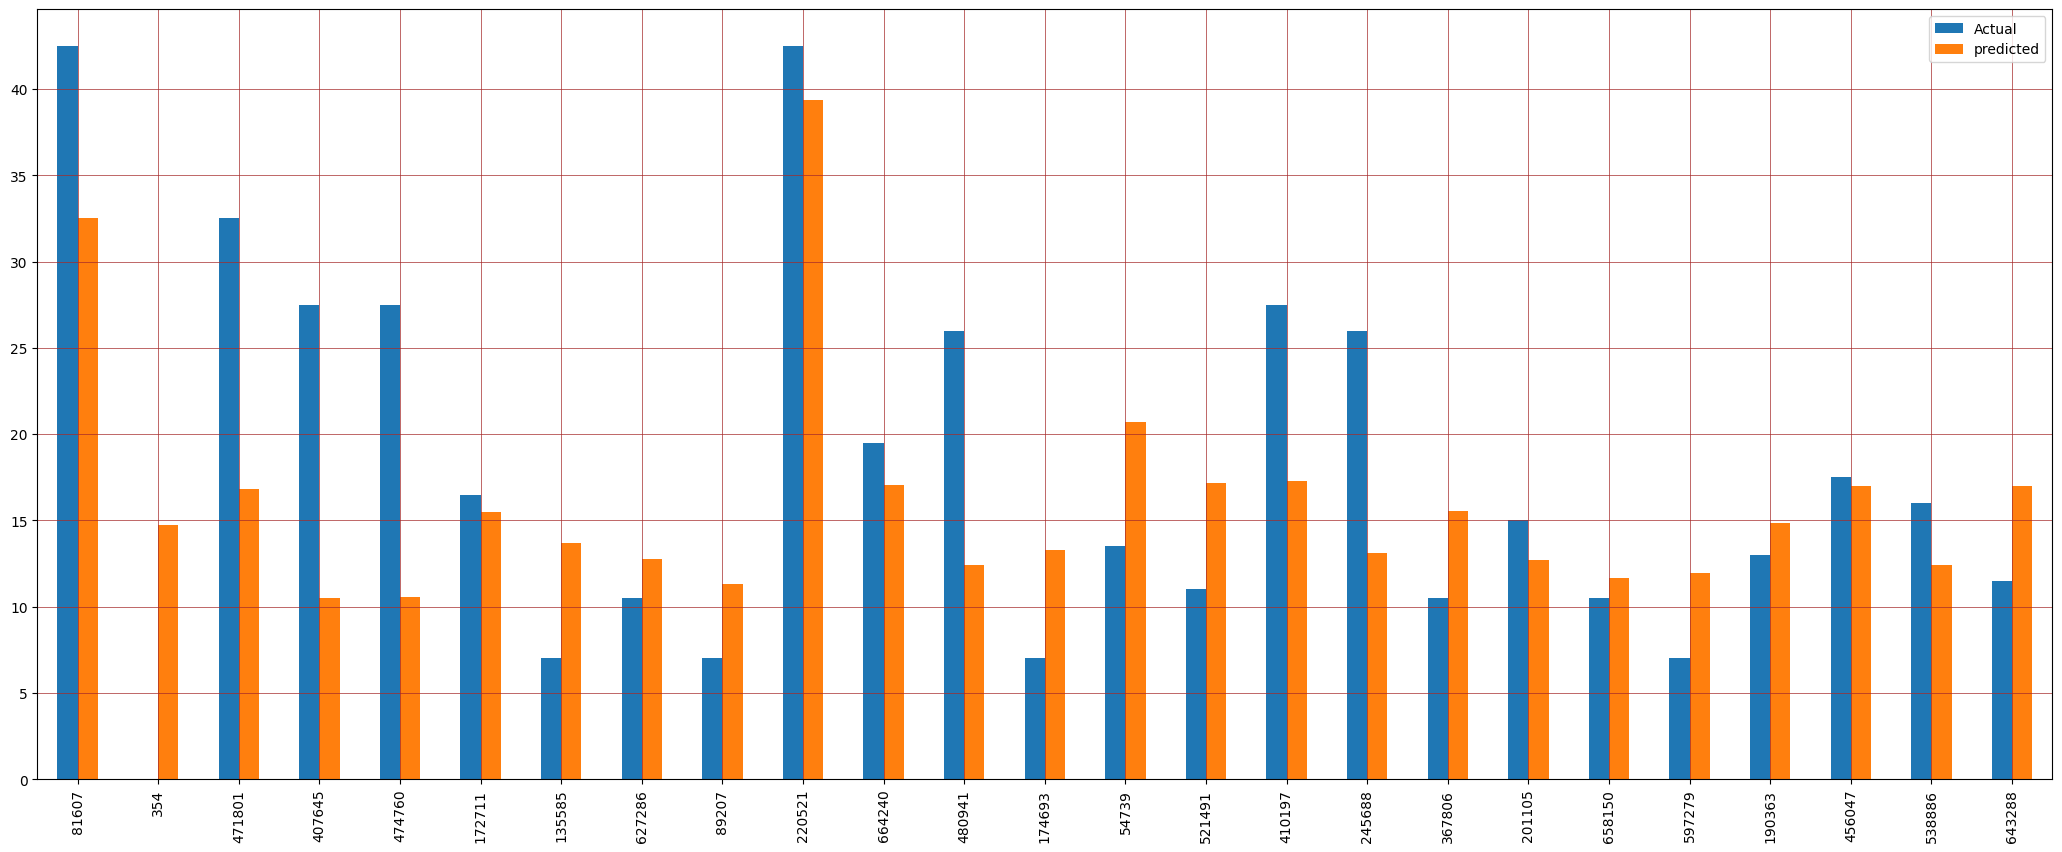

In [83]:
df1 = df.head(25)
df1.plot.bar(figsize=(26,10))
plt.grid(which='major',linestyle='-',linewidth='0.5',color='brown')
plt.grid(which='minor',linestyle=':',linewidth='0.5',color='black')
plt.show()

End